# ROB 498: Robot Learning for Planning and Control
# Assignment 6: Reinforcement Learning

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW4 folder, then 'ROB498/HW4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB 498/Homeworks/HW6'

### Setup Code

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw6.ipynb', 'panda_pushing_env.py', 'visualizers.py', 'pushing_rl.py']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

All required files are found :)


In [5]:
# Install missing required packages
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install stable-baselines -- For RL implementations
!pip install stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 

In [6]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Reinforcement Learning for Planar Pushing (100 points)

We will be applying model-free reinforcement learning to the planar block pushing task that you have seen in homeworks 3 and 5.

Rather than implement your own RL algorithms, in this homework you will use [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/). Stable-Baselines3 has implementations of a variety of different RL algorithms for you to use, and it is recommended that use these implementations rather than implement the RL algorithms yourself.

For this homework you will use PPO to learn a policy for the block planar pushing task. For more details about the PPO implementation, check out the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) page.


# 1 - PPO on Object Pose Space:

In [7]:
from panda_pushing_env import PandaPushingEnv, TARGET_POSE, OBSTACLE_CENTRE, OBSTACLE_HALFDIMS, BOX_SIZE
from visualizers import GIFVisualizer, NotebookVisualizer

from pushing_rl import *

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1.1 - Obstacle Free Pushing
In this section you will implement a reward function for the RL algorithm for the case where there are no obstacles on the table. The reward function you choose is completely up to you. We will only evaluate the resulting policy on task performance.

Some tips for your reward function
- In general dense rewards perform better than sparse rewards. A sparse reward is a reward that gives sparse signals, for example, a high reward for successfully completing the task. A dense reward gives signals at every timestep of the episode, for example, the distance to goal.
- It is a good idea to combine a dense reward such as distance to goal with a large reward for task completion
- You may want to give a negative reward for task failure, such as the block leaving the allowable region.

You should upload the trained policy to autograder. The autograder will run the policy 10 times and will pause if the policy succeeds once.

**TODO**:
* From `pushing_rl.py` edit the `obstacle_free_pushing_reward_function_object_pose_space`. The goal pose is `TARGET_POSE` which is a global variable
* From `pushing_rl.py` complete the `execute_policy`. We will use this for rolling out trajectories using the learned policy.

[0.8 0.  0. ]


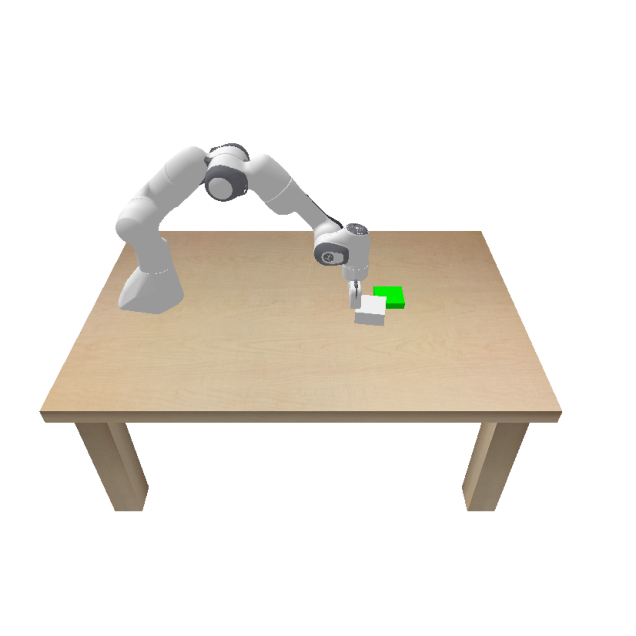

[ 0.3499256  -1.0669438   0.17446227]
[ 0.3497172  -1.3501356   0.21496955]
[-0.60516685 -0.61594737  0.13225631]
[ 0.59290916 -0.5827648   0.9149412 ]
[ 0.50702834 -0.80428416  0.8630906 ]
[-0.41062078  0.11228248  0.87178344]
[ 0.8955482 -1.0767528  0.6808809]
[-0.3471696  -0.02320341  0.62888384]
[ 0.93274415 -0.28608695  0.500821  ]
[0.2979947  0.2265459  0.07646648]
GOAL REACHED: True
State [ 0.4077217  -0.00698228 -0.6179896 ] has a reward 10
State [ 0.4132415  -0.01003343 -0.60861117] has a reward 10
State [ 0.41872382 -0.01471049 -0.4984994 ] has a reward 10
State [ 0.4812259  -0.05121219 -0.30160907] has a reward 10
State [ 0.5247138  -0.06803211 -0.04070652] has a reward 10
State [ 0.60649836 -0.06525173  0.02140596] has a reward 10
State [ 0.6329577  -0.06769345  0.00884165] has a reward 10
State [ 0.69054407 -0.06721233  0.03494494] has a reward 500
State [ 0.7282782  -0.07058851 -0.15080573] has a reward 500
State [ 0.7302595  -0.07083386 -0.15031159] has a reward 500


In [16]:
%matplotlib inline
print(TARGET_POSE)

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=3,
                                camera_heigh=800,
                                camera_width=800)
env.reset()



# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)

states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=20)


# print(states)
#### WHAT DOES THE ACTION COMPRISE OF IN PHYSICAL SENSE

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')

### Apply Stable Baselines:

In [17]:
#live_display.stop()
total_timesteps = 2000 # You may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space)
env.reset()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=total_timesteps, progress_bar=True)
model.save("free_pushing_object_pose")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.3     |
|    ep_rew_mean     | 1.14e+03 |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 1579     |
|    total_timesteps | 2048     |
---------------------------------


Visualize the learned policy performance:

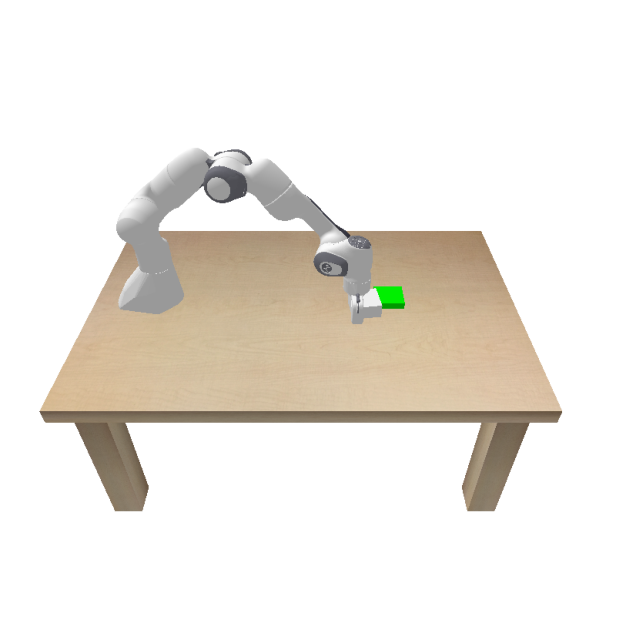

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


[-0.09698111 -0.92543364  0.283628  ]
[ 0.11326943 -0.8979156   0.95431703]
[-1.        -1.5707964  0.       ]
[-0.01127644 -0.20824587  0.        ]
[0.16504371 0.6192257  0.        ]
[0.3158982  0.05496781 0.61941093]
[-0.47948313  0.26312292  0.14429611]
[1.        1.5707964 0.       ]
[ 0.41755438 -0.71958065  0.        ]
[0.5428825 0.6562717 0.       ]
[-0.8659004  0.6826108  1.       ]
[0.20567425 0.575426   0.        ]
[0.03212865 0.6938457  0.        ]
[-1.        -0.0048118  0.       ]
[-0.06656355  1.5707964   0.        ]
[ 0.07262342 -0.5526458   0.03290867]
[-0.5955734   0.785768    0.03663925]
[0.94417703 0.3634925  0.        ]
[ 0.34526128 -1.1163542   0.19393054]
[ 0.75715    -0.09067379  0.        ]
[ 0.26890954 -0.08078118  0.        ]
[-0.20321004  1.136036    0.3728678 ]
[1.        1.1764687 0.       ]
[1.        1.0984629 1.       ]
[0.28801593 0.15730128 0.        ]
[-1.         0.7789571  0.       ]
[-0.17645882 -1.5707964   0.        ]
[0.16075878 0.60332704 0.   

In [18]:
%matplotlib inline
model = PPO.load("free_pushing_object_pose")
# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                camera_heigh=800,
                                camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, model, num_steps)

print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)

## 1.2 - Pushing with Obstacles
In this section you will implement a reward function for the RL algorithm for the case where there is an obstacle on the table. The position and dimensions of the obstacle is given as global variables `OBSTACLE_CENTRE` and `OBSTACLE_HALFDIMS`. As before, the reward function you choose is completely up to you. We will only evaluate the resulting policy on task performance.

While you may be able to use the same reward function as the obstacle-free case to successfully learn a policy, you may find that incorporating a collision check into the reward can lead to faster learning.

You should upload the trained policy to autograder. The autograder will run the policy 10 times and will pause if the policy succeeds once.

**TODO**:
* From `pushing_rl.py` edit the `pushing_with_obstacles_reward_function_object_pose_space`. The goal pose is `TARGET_POSE` which is a global variable

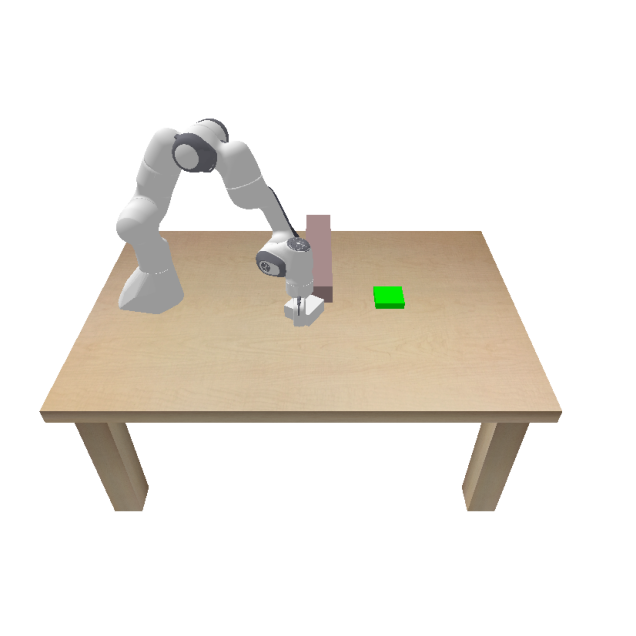

[-0.7601139   1.4987963   0.84343153]
[-0.6209883   1.0515727   0.06215505]
[ 0.01776311 -0.3356631   0.5592698 ]
[-0.32800764 -1.2798208   0.20116766]
[-0.001073  -0.4435781  0.8296888]
[-0.7590386  0.6121963  0.5071365]


KeyboardInterrupt: 

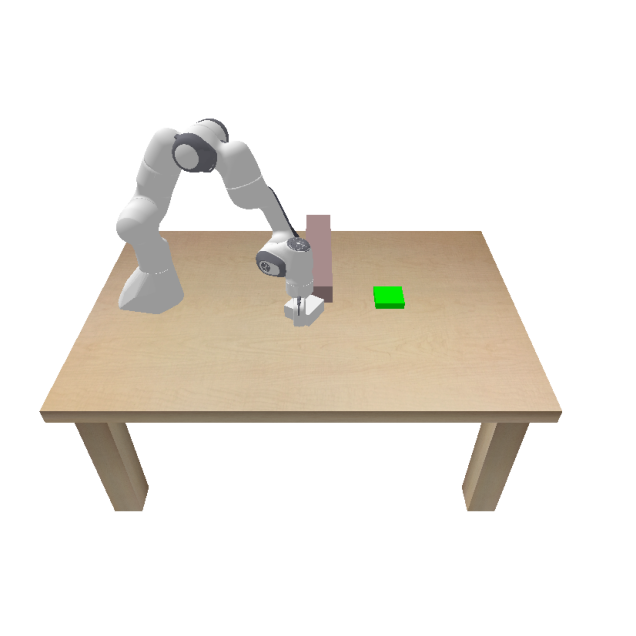

In [12]:
# visualize the obstacle env
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space,
                                include_obstacle=True,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=5,
                                camera_heigh=800,
                                camera_width=800)
env.reset()



# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)

states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=30)

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')


In [13]:
total_timesteps = 1000 # You may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space, include_obstacle=True)
env.reset()
obstacle_policy_model = PPO("MlpPolicy", env, verbose=1)
obstacle_policy_model.learn(total_timesteps=total_timesteps, progress_bar=True)
obstacle_policy_model.save("obstacle_pushing_object_pose")

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


KeyboardInterrupt: 

Visualize the performance:

In [9]:
%matplotlib inline
obstacle_policy_model = PPO.load("free_pushing_object_pose")

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose',
                                reward_function=pushing_with_obstacles_reward_function_object_pose_space,
                                include_obstacle=True,
                                visualizer=visualizer,
                                render_non_push_motions=False,
                                render_every_n_steps=5,
                                camera_heigh=800,
                                camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, obstacle_policy_model, num_steps)

print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)

FileNotFoundError: [Errno 2] No such file or directory: 'free_pushing_object_pose.zip'